# PROJECT 14 폐렴 진단기

X-RAY 이미지를 기반으로 하는 폐렴 진단 딥러닝 모델을 제작해보자!

## 1. X-RAY 이미지

### X-RAY 란?
> X-RAY 는 전자기파가 몸을 통과한 결과를 이미지화 시킨 것입니다.  

X-RAY 는 부위에 따라서 명암이 다르게 나옵니다.  


![x_ray](image/x_ray.png)
(출처 : http://health.cdc.go.kr/health/Resource/Module/Content/Printok.do?idx=2110&subIdx=4)  
</br>  
</br>  
</br>  
위 사진은 흉부를 X-RAY로 찍은 사진입니다.  
- 갈비뼈 : 하얀색  
- 폐 : 검은색  
- 어깨 쪽의 지방 및 근육 : 회색  

## 2. 폐렴 구별법

![chest_x_ray](image/chest_x_ray.png)
(출처 : https://www.news-medical.net/news/20201218/Transfer-learning-exploits-chest-Xray-to-diagnose-COVID-19-pneumonia.aspx)

### 정상적인 폐 X-RAY
> X-RAY 사진상, 음영 영역이 없는 깨끗한 폐가 관찰됩니다.  

### 폐렴 X-RAY
> X-RAY 사진상, 폐 부위에 희미한 그림자가 관찰됩니다.  

## 3. Set-up

### 패키지 및 라이브러리
가장 먼저, 패키지들을 import 합니다.

In [54]:
import re    # 정규표현식 관련된 작업에 필요한 패키지
import os    # I/O 관련된 작업에 필요한 패키지 
import pandas as pd     # 데이터 전처리 관련된 작업에 필요한 패키지
import numpy as np      # 데이터 array 작업에 필요한 패키지
import tensorflow as tf  # 딥러닝 관련된 작업에 필요한 패키지
import matplotlib.pyplot as plt    # 데이터 시각화에 관련된 작업에 필요한 패키지
import matplotlib.image as img    # 데이터 시각화에 관련된 작업에 필요한 패키지
from sklearn.model_selection import train_test_split  # 데이터 전처리에 필요한 패키지

### 변수

앞으로 필요한 변수들을 생성합니다.

In [55]:
# 데이터 로드할 때 빠르게 로드할 수 있도록하는 설정 변수
AUTOTUNE = tf.data.experimental.AUTOTUNE

# 데이터 ROOT 경로 변수
ROOT_PATH = os.path.join(os.getenv('HOME'), 'aiffel')

# BATCH_SIZE 변수
BATCH_SIZE = 16

# X-RAY 이미지 사이즈 변수
IMAGE_SIZE = [180, 180]

# EPOCH 크기 변수
EPOCHS = 25

print(ROOT_PATH)

/home/aiffel-dj41/aiffel


## 4. 데이터 준비하기

### 데이터 로드
폴더에서 x_ray 이미지를 가져옵니다. 

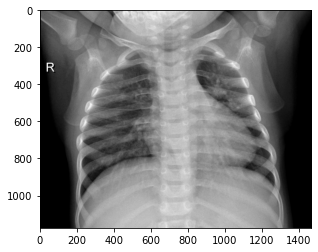

train data 갯수 : 5216
test data 갯수 : 624
validation 갯수 : 16


In [56]:
train_filenames = tf.io.gfile.glob(str(ROOT_PATH + '/exploration/chest_xray/train/*/*'))
test_filenames = tf.io.gfile.glob(str(ROOT_PATH + '/exploration/chest_xray/test/*/*'))
val_filenames = tf.io.gfile.glob(str(ROOT_PATH + '/exploration/chest_xray/val/*/*'))

plt.imshow(img.imread(train_filenames[0]), cmap='gray')
plt.show()

print("train data 갯수 :", len(train_filenames))
print("test data 갯수 :", len(test_filenames))
print("validation 갯수 :", len(val_filenames))

train 데이터는 5,216 개, test 데이터는 624개, validation 데이터는 16개 입니다.  
validation 데이터가 너무 없기 때문에 train 데이터에서 validation 데이터에 쓰일 데이터를 가져오도록 하겠습니다.  

### 데이터 갯수 조정
train 데이터와 validation 데이터를 하나로 모은 다음, train : validation 을 8:2 비율로 나누도록 하겠습니다.

In [58]:
filenames = tf.io.gfile.glob(str(ROOT_PATH + '/exploration/chest_xray/train/*/*'))
filenames.extend(tf.io.gfile.glob(str(ROOT_PATH + '/exploration/chest_xray/val/*/*')))

# train, test(val) dataset으로 분할. test_size에 0.2는 20%롤 의미함.
train_filenames, val_filenames = train_test_split(filenames, test_size=0.2)

print("train data 갯수 :", len(train_filenames))
print("validation 갯수 :", len(val_filenames))

train data 갯수 : 4185
validation 갯수 : 1047


train 데이터는 5,216개 에서 4,185개로 줄어들었고, validaion 데이터는 16개에서 1,047개로 늘어났습니다.

### 정상 이미지 개수 vs 폐렴 이미지 개수

In [59]:
COUNT_NORMAL = len([filename for filename in train_filenames if "NORMAL" in filename])
print("Normal images count in training set: " + str(COUNT_NORMAL))

COUNT_PNEUMONIA = len([filename for filename in train_filenames if "PNEUMONIA" in filename])
print("Pneumonia images count in training set: " + str(COUNT_PNEUMONIA))

Normal images count in training set: 1090
Pneumonia images count in training set: 3095


정상 이미지보다 폐렴 이미지가 약 3배 더 많이 있습니다. 즉, 이 데이터는 imbalance 한 데이터 입니다.  
imbalance 한 데이터는 학습에 영향을 주기 때문에 변형을 시켜줘야 합니다.  
imbalance 한 데이터는 모델링하는 과정에서 조정하도록 하겠습니다.

### 데이터셋 생성
tf.data.Dataset.from_tensor_slices() 함수를 사용하여 train 데이터와 validation 데이터를 dataset 으로 변환합니다.  

In [60]:
train_list_ds = tf.data.Dataset.from_tensor_slices(train_filenames)
val_list_ds = tf.data.Dataset.from_tensor_slices(val_filenames)
test_list_ds = tf.data.Dataset.from_tensor_slices(test_filenames)

In [61]:
TRAIN_IMG_COUNT = tf.data.experimental.cardinality(train_list_ds).numpy()
print("Training images count: " + str(TRAIN_IMG_COUNT))

VAL_IMG_COUNT = tf.data.experimental.cardinality(val_list_ds).numpy()
print("Validating images count: " + str(VAL_IMG_COUNT))

TEST_IMG_COUNT = tf.data.experimental.cardinality(test_list_ds).numpy()
print("Tesing images count: " + str(TEST_IMG_COUNT))

CLASS_NAMES = np.array([str(tf.strings.split(item, os.path.sep)[-1].numpy())[2:-1]
                        for item in tf.io.gfile.glob(str(ROOT_PATH + "/exploration/chest_xray/train/*"))])
print("Label names : " + str(CLASS_NAMES))

Training images count: 4185
Validating images count: 1047
Tesing images count: 624
Label names : ['NORMAL' 'PNEUMONIA']


### 라벨 데이터 생성
현재의 이미지에는 라벨 데이터가 따로 없기때문에 라벨 데이터를 따로 생성하도록 하겠습니다.

In [62]:
def get_label(file_path):
    parts = tf.strings.split(file_path, os.path.sep)
    return parts[-2] == "PNEUMONIA"   # 폐렴이면 양성(True), 노말이면 음성(False)를 리턴하게 합니다.

In [63]:
def decode_img(img):
  # 이미지를 uint8 tensor로 바꾼다.
  img = tf.image.decode_jpeg(img, channels=3)
  # img를 범위 [0,1]의 float32 데이터 타입으로 바꾼다.
  img = tf.image.convert_image_dtype(img, tf.float32)
  # img의 이미지 사이즈를 IMAGE_SIZE에서 지정한 사이즈로 수정한다.
  return tf.image.resize(img, IMAGE_SIZE)

def process_path(file_path):
    label = get_label(file_path)
    img = tf.io.read_file(file_path)
    img = decode_img(img)
    return img, label

In [64]:
train_pre_ds = train_list_ds.map(process_path, num_parallel_calls=AUTOTUNE)
val_pre_ds = val_list_ds.map(process_path, num_parallel_calls=AUTOTUNE)
test_ds = test_list_ds.map(process_path, num_parallel_calls=AUTOTUNE)

In [65]:
for image, label in train_pre_ds.take(5):
    print("Image shape: ", image.numpy().shape)
    print("Label: ", label.numpy())
    print()

Image shape:  (180, 180, 3)
Label:  True

Image shape:  (180, 180, 3)
Label:  True

Image shape:  (180, 180, 3)
Label:  False

Image shape:  (180, 180, 3)
Label:  True

Image shape:  (180, 180, 3)
Label:  False



### 효율적인 학습 데이터로 변환
prepare_for_training() 함수를 사용하여 학습 데이터를 효율적으로 할 수 있도록 데이터를 변환 시켜줍니다.

In [66]:
def prepare_for_training(ds, shuffle_buffer_size=1000):

    ds = ds.shuffle(buffer_size=shuffle_buffer_size, seed=2021)    # 무작위로 섞기

    ds = ds.repeat()    # epoch 진행시, 여러번 데이터 셋을 사용하기

    ds = ds.batch(BATCH_SIZE)

    ds = ds.prefetch(buffer_size=AUTOTUNE)    # 학습데이터를 나눠서 읽어오기

    return ds

train_ds = prepare_for_training(train_pre_ds)
val_ds = prepare_for_training(val_pre_ds)
test_ds = test_ds.batch(BATCH_SIZE)

### 데이터 시각화
train 데이터에 있는 batch 중 첫 번째 배치를 추출한 후, 추출된 배치를 image 와 label 떼이터 셋으로 나누어서 시각화 해보도록 하겠습니다.

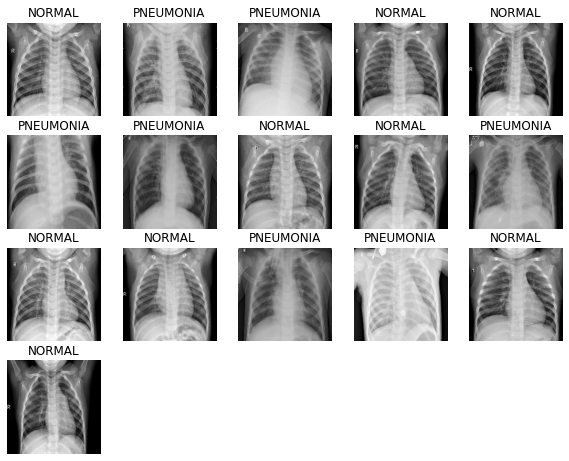

In [67]:
image_batch, label_batch = next(iter(train_ds))

def show_batch(image_batch, label_batch):
    plt.figure(figsize=(10,10))
    for n in range(16):
        ax = plt.subplot(5,5,n+1)
        plt.imshow(image_batch[n])
        if label_batch[n]:
            plt.title("PNEUMONIA")
        else:
            plt.title("NORMAL")
        plt.axis("off")

show_batch(image_batch.numpy(), label_batch.numpy())

## 5. 모델링하기

### CNN 모델링
가장 대표적인 딥러닝 모델인 CNN 을 모델링하도록 하겠습니다.  

- Convolution block 만들기  
Convolution 을 2번 진행하고, Batch Normalization 을 진행한 다음, Max Pooling 을 합니다.

In [68]:
def conv_block(filters):
    block = tf.keras.Sequential([
        tf.keras.layers.SeparableConv2D(filters, 3, activation='relu', padding='same'),
        tf.keras.layers.SeparableConv2D(filters, 3, activation='relu', padding='same'),
        tf.keras.layers.BatchNormalization(),
        tf.keras.layers.MaxPool2D()])
    
    return block

- Dense Block 만들기  
Dense 층을 쌓고, Batch Nomarlization 을 진행한 다음, Dropout 을 합니다.

In [69]:
def dense_block(units, dropout_rate):
    block = tf.keras.Sequential([
        tf.keras.layers.Dense(units, activation='relu'),
        tf.keras.layers.BatchNormalization(),
        tf.keras.layers.Dropout(dropout_rate)])
    
    return block

- 전체적인 모델 만들기  

In [70]:
def build_model():
    model = tf.keras.Sequential([
        tf.keras.Input(shape=(IMAGE_SIZE[0], IMAGE_SIZE[1], 3)),
        
        tf.keras.layers.Conv2D(16, 3, activation='relu', padding='same'),
        tf.keras.layers.Conv2D(16, 3, activation='relu', padding='same'),
        tf.keras.layers.MaxPool2D(),
        
        conv_block(32),
        conv_block(64),
        
        conv_block(128),
        tf.keras.layers.Dropout(0.2),
        
        conv_block(256),
        tf.keras.layers.Dropout(0.2),
        
        tf.keras.layers.Flatten(),
        dense_block(512, 0.7),
        dense_block(128, 0.5),
        dense_block(64, 0.3),
        
        tf.keras.layers.Dense(1, activation='sigmoid')])
    
    return model

### imbalance한 데이터 처리
지금 현재 데이터는 imbalance 합니다. 'Normal' 보다 'Pneumonia' 데이터가 더 많이 있었기 때문입니다. 한 라벨이 너무 많으면, 데이터를 학습할 때 학습 효과가 좋지 않을수 있습니다.  
imbalance 한 데이터는 Weight balancing 기술을 사용하여 해결할 수 있습니다.

> **Weight balancing**  
훈련 데이터 셋의 각 데이터에서 loss를 계산할 때, 특정 클래스의 데이터에 더 큰 loss 값을 갖도록 가중치를 부여하는 방법

가중치 값은 'Normal' 과 'Pneumonia' 전체 데이터 건수에 반비례하도록 설정하도록 하겠습니다.

In [71]:
weight_for_0 = (1 / COUNT_NORMAL)*(TRAIN_IMG_COUNT)/2.0    # NORMAL
weight_for_1 = (1 / COUNT_PNEUMONIA)*(TRAIN_IMG_COUNT)/2.0    # PNEUMONIA

class_weight = {0: weight_for_0, 1: weight_for_1}

print('Weight for class 0 (NORMAL) : {:.2f}'.format(weight_for_0))
print('Weight for class 1 (PNEUMONIA) : {:.2f}'.format(weight_for_1))

Weight for class 0 (NORMAL) : 1.92
Weight for class 1 (PNEUMONIA) : 0.68


## 6. 모델 훈련하기
GPU를 사용하여 모델을 훈련하도록 하겠습니다.

이미지의 라벨은 두 개 밖에 없기 때문에 "binary_cross entropy" loss를 사용합니다. optimizer 로 'adam' 을 사용합니다.  
성과에 대해서 측정하기 위한 metrics 로 'accuracy', 'precision', 'recall'을 사용합니다.

In [72]:
with tf.device('/GPU:0'):
    model = build_model()

    METRICS = [
        'accuracy',
        tf.keras.metrics.Precision(name='precision'),
        tf.keras.metrics.Recall(name='recall')
    ]
    
    model.compile(
        optimizer='adam',
        loss='binary_crossentropy',
        metrics=METRICS
    )

모델을 fit 합니다.

In [73]:
with tf.device('/GPU:0'):
    history = model.fit(
        train_ds,
        steps_per_epoch=TRAIN_IMG_COUNT // BATCH_SIZE,
        epochs=EPOCHS,
        validation_data=val_ds,
        validation_steps=VAL_IMG_COUNT // BATCH_SIZE,
        class_weight=class_weight,
    )

Epoch 1/25
261/261 [==============================] - 25s 96ms/step - loss: 0.3693 - accuracy: 0.8362 - precision: 0.9563 - recall: 0.8157 - val_loss: 0.6532 - val_accuracy: 0.7529 - val_precision: 0.7529 - val_recall: 1.0000
Epoch 2/25
261/261 [==============================] - 25s 94ms/step - loss: 0.2320 - accuracy: 0.9133 - precision: 0.9726 - recall: 0.9084 - val_loss: 1.3885 - val_accuracy: 0.7529 - val_precision: 0.7529 - val_recall: 1.0000
Epoch 3/25
261/261 [==============================] - 25s 96ms/step - loss: 0.1997 - accuracy: 0.9253 - precision: 0.9760 - recall: 0.9216 - val_loss: 0.2033 - val_accuracy: 0.9029 - val_precision: 0.8867 - val_recall: 0.9987
Epoch 4/25
261/261 [==============================] - 25s 96ms/step - loss: 0.1811 - accuracy: 0.9330 - precision: 0.9809 - recall: 0.9276 - val_loss: 0.0972 - val_accuracy: 0.9635 - val_precision: 0.9844 - val_recall: 0.9668
Epoch 5/25
261/261 [==============================] - 25s 95ms/step - loss: 0.1722 - accuracy: 0

## 7. 결과 확인하기
그래프로 Epochs 마다 모델의 precision, recall, accuracy, loss가 어떻게 변하는지 확인해보도록 하겠습니다.

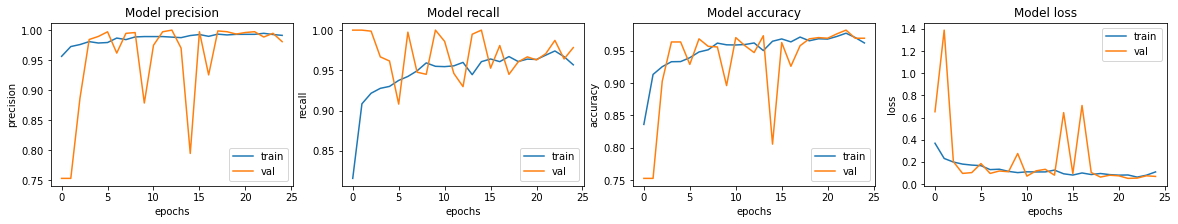

In [74]:
fig, ax = plt.subplots(1, 4, figsize=(20, 3))
ax = ax.ravel()

for i, met in enumerate(['precision', 'recall', 'accuracy', 'loss']):
    ax[i].plot(history.history[met])
    ax[i].plot(history.history['val_' + met])
    ax[i].set_title('Model {}'.format(met))
    ax[i].set_xlabel('epochs')
    ax[i].set_ylabel(met)
    ax[i].legend(['train', 'val'])

In [75]:
loss, acc, prec, rec = model.evaluate(test_ds)

39/39 [==============================] - 2s 60ms/step - loss: 0.8369 - accuracy: 0.8109 - precision: 0.7731 - recall: 0.9872


폐렴 진단에 있어서 약 81% 정도 맞출 수 있게 되었습니다.  
저의 목표는 85% 이상의 정확도를 얻는 것이기 때문에 Data augmentation 방법을 통해 성능을 개선해 보도록학습니다.

> **Data Augmentation 이란?**  
레이블에 존재하는 데이터에 변화를 줘 원본 데이터와 같은 레이블을 가지는 새로운 데이터를 만드는 방법입니다.  
*ex) 이미지 회전 및 확대, 가우시안 노이즈 추가*

## 8. 성능 개선하기

### Data Augmentation
- 이미지 좌우반전을 사용하도록 하겠습니다.

In [76]:
def augment(image,label):
    image = tf.image.random_flip_left_right(image)  # 랜덤하게 좌우를 반전합니다.
    return image,label

def prepare_for_training(ds, shuffle_buffer_size=1000):
    # augment 적용 부분이 배치처리 함수에 추가되었습니다.
    ds = ds.map(
            augment,       # augment 함수 적용
            num_parallel_calls=2
        )

    ds = ds.shuffle(buffer_size=shuffle_buffer_size)

    ds = ds.repeat()

    ds = ds.batch(BATCH_SIZE)

    ds = ds.prefetch(buffer_size=AUTOTUNE)

    return ds

train_ds = prepare_for_training(train_pre_ds)
val_ds = prepare_for_training(val_pre_ds)

### 데이터 시각화
show_batch() 함수를 통해 실제로 좌우반전이 처리되었는지 확인해 보도록 하겠습니다.

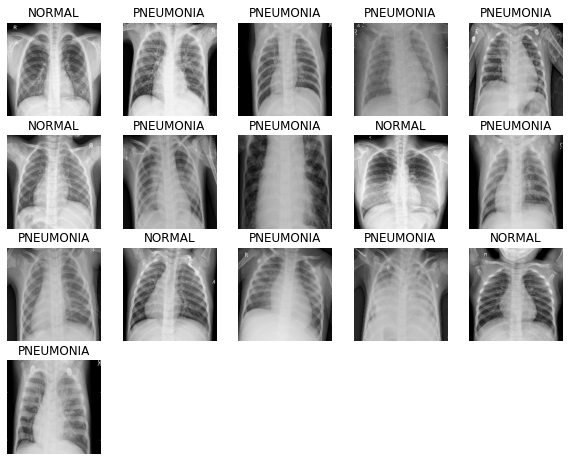

In [77]:
image_batch, label_batch = next(iter(train_ds))

show_batch(image_batch.numpy(), label_batch.numpy())

### 모델 훈련
learning rate 를 0.01 로 설정하여 모델을 훈련시키도록 하겠습니다.

In [101]:
with tf.device('/GPU:0'):
    model = build_model()

    METRICS = [
        'accuracy',
        tf.keras.metrics.Precision(name='precision'),
        tf.keras.metrics.Recall(name='recall')
    ]
    
    model.compile(
        optimizer=tf.keras.optimizers.Adam(lr=0.01),
        loss='binary_crossentropy',
        metrics=METRICS,
    )

In [102]:
with tf.device('/GPU:0'):
    history = model.fit(
        train_ds,
        steps_per_epoch=TRAIN_IMG_COUNT // BATCH_SIZE,
        epochs=25,
        validation_data=val_ds,
        validation_steps=VAL_IMG_COUNT // BATCH_SIZE,
        class_weight=class_weight,
    )

Epoch 1/25
261/261 [==============================] - 25s 94ms/step - loss: 0.5130 - accuracy: 0.7514 - precision: 0.9057 - recall: 0.7408 - val_loss: 1.0839 - val_accuracy: 0.7519 - val_precision: 0.7746 - val_recall: 0.9450
Epoch 2/25
261/261 [==============================] - 24s 94ms/step - loss: 0.3558 - accuracy: 0.8429 - precision: 0.9406 - recall: 0.8408 - val_loss: 0.9770 - val_accuracy: 0.6990 - val_precision: 0.9875 - val_recall: 0.6074
Epoch 3/25
261/261 [==============================] - 24s 93ms/step - loss: 0.3470 - accuracy: 0.8573 - precision: 0.9495 - recall: 0.8522 - val_loss: 0.3385 - val_accuracy: 0.8394 - val_precision: 0.8639 - val_recall: 0.9335
Epoch 4/25
261/261 [==============================] - 24s 93ms/step - loss: 0.2799 - accuracy: 0.8805 - precision: 0.9629 - recall: 0.8723 - val_loss: 0.5779 - val_accuracy: 0.7587 - val_precision: 0.7626 - val_recall: 0.9859
Epoch 5/25
261/261 [==============================] - 25s 95ms/step - loss: 0.2323 - accuracy: 0

### 결과확인 및 시각화

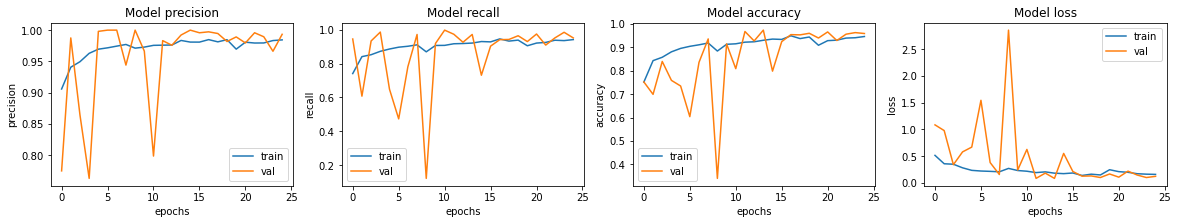

In [103]:
fig, ax = plt.subplots(1, 4, figsize=(20, 3))
ax = ax.ravel()

for i, met in enumerate(['precision', 'recall', 'accuracy', 'loss']):
    ax[i].plot(history.history[met])
    ax[i].plot(history.history['val_' + met])
    ax[i].set_title('Model {}'.format(met))
    ax[i].set_xlabel('epochs')
    ax[i].set_ylabel(met)
    ax[i].legend(['train', 'val'])

In [104]:
loss, acc, prec, rec = model.evaluate(test_ds)

39/39 [==============================] - 3s 69ms/step - loss: 0.3764 - accuracy: 0.8606 - precision: 0.8374 - recall: 0.9641


이미지 좌우 반전의 augmentation 과 learning rate 를 0.01 로 설정을 하여 모델을 훈련을 시켰더니 86%의 정확도를 얻게 되었습니다.

# [ 결과 - 루브릭 ]
**1. 의료영상을 처리하는 CNN 기반 딥러닝 모델이 잘 구현되었다.**
- 모델 학습이 안정적으로 수렴하는 것을 시각화를 통해 확인하였습니다. :)  

**2. 데이터 준비, 모델구성 등의 과정의 다양한 실험이 체계적으로 수행되었다.** 
- Weight balancing, augmentation 등의 기법의 사용 여부에 따른 모델 성능을 측정하였습니다. :)
  
**3. 실습코드를 잘 개선하여 폐렴 검출 정확도가 추가로 향상되었다.**
- 모델 성능을 개선하여 Accuracy가 81% 에서 86%로 상승하였습니다. :)